BertEmbedder initialized on device: cpu
Данные готовы. Обучающая выборка: 1663, Тестовая: 555

--- Шаг 2: Обучение CatBoost ---
Модель CatBoost обучена.

--- Шаг 3: Оценка со строгим порогом ---
Используемый порог принятия решения: 0.85

--- Финальный отчет для CatBoost со строгим порогом ---
              precision    recall  f1-score   support

   other (0)       0.72      0.86      0.78        50
  inlier (1)       0.99      0.97      0.98       505

    accuracy                           0.96       555
   macro avg       0.85      0.91      0.88       555
weighted avg       0.96      0.96      0.96       555

Количество ложноположительных срабатываний (пропущенный 'мусор'): 7
Количество ложноотрицательных срабатываний (потерянные 'свои' команды): 17

--- Шаг 4: Матрица ошибок ---


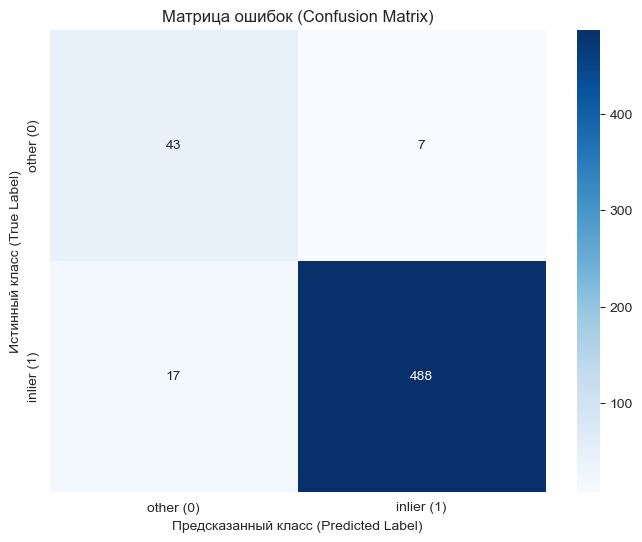

In [ ]:
# Experiment 1

import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

class BertEmbedder:
    """
    Класс для получения эмбеддингов из [CLS] токена модели ruBERT.
    """
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
        self.model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
        self.device = torch.device("cuda" if torch..is_available() else "cpu")
        self.model.to(self.device)
        print(f"BertEmbedder initialized on device: {self.device}")

    def embed(self, text: str) -> np.ndarray:
        t = self.tokenizer(text, padding=True, truncation=True, return_tensors="pt")
        t = {k: v.to(self.device) for k, v in t.items()}
        with torch.no_grad():
            model_output = self.model(**t)
        embeddings = model_output.last_hidden_state[:, 0, :]
        embeddings = torch.nn.functional.normalize(embeddings)
        return embeddings[0].cpu().numpy()


data = pd.read_csv("dataset_6k_10_classes.csv", delimiter=";")
y_labels = (data['label'] != 'other').astype(int)
embedder = BertEmbedder()
X_embeddings = [embedder.embed(text) for text in data["text"]]
X_train, X_test, y_train, y_test = train_test_split(
    X_embeddings, y_labels, test_size=0.25, random_state=42, stratify=y_labels
)
print(f"Данные готовы. Обучающая выборка: {len(X_train)}, Тестовая: {len(X_test)}")

print("\n--- Шаг 2: Обучение CatBoost ---")
count_neg = np.sum(y_train == 0)
count_pos = np.sum(y_train == 1)
scale_pos_weight_value = count_neg / count_pos if count_pos > 0 else 1

classifier_cb = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    scale_pos_weight=scale_pos_weight_value,
    random_state=42,
    verbose=0
)
classifier_cb.fit(X_train, y_train)
print("Модель CatBoost обучена.")


# --- ШАГ 3: ПРИМЕНЕНИЕ СТРОГОГО ПОРОГА И ФИНАЛЬНАЯ ОЦЕНКА ---
print("\n--- Шаг 3: Оценка со строгим порогом ---")

predicted_probas = classifier_cb.predict_proba(X_test)[:, 1]
new_threshold = 0.85 # 0.92
print(f"Используемый порог принятия решения: {new_threshold}")
y_pred_final = (predicted_probas >= new_threshold).astype(int)

print("\n--- Финальный отчет для CatBoost со строгим порогом ---")
print(classification_report(y_test, y_pred_final, target_names=['other (0)', 'inlier (1)']))

fp_count = np.sum((y_pred_final == 1) & (y_test == 0))
fn_count = np.sum((y_pred_final == 0) & (y_test == 1))

print(f"Количество ложноположительных срабатываний (пропущенный 'мусор'): {fp_count}")
print(f"Количество ложноотрицательных срабатываний (потерянные 'свои' команды): {fn_count}")


# --- ШАГ 4: ВИЗУАЛИЗАЦИЯ МАТРИЦЫ ОШИБОК ---
print("\n--- Шаг 4: Матрица ошибок ---")
cm = confusion_matrix(y_test, y_pred_final)
class_names = ['other (0)', 'inlier (1)']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Матрица ошибок (Confusion Matrix)')
plt.ylabel('Истинный класс (True Label)')
plt.xlabel('Предсказанный класс (Predicted Label)')
plt.show()

BertEmbedder initialized on cpu
Train: 1663 — Test: 555

—— Binary report ——
              precision    recall  f1-score   support

    other(0)       0.72      0.86      0.78        50
   inlier(1)       0.99      0.97      0.98       505

    accuracy                           0.96       555
   macro avg       0.85      0.91      0.88       555
weighted avg       0.96      0.96      0.96       555

FP: 7 | FN: 17


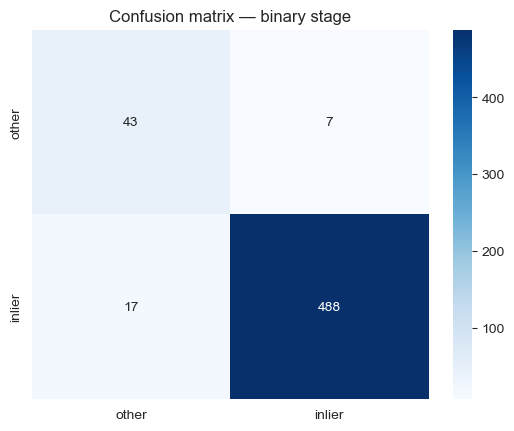


—— Multiclass report (on predicted inliers) ——
                            precision    recall  f1-score   support

              accept_order       0.84      0.93      0.89        46
               build_route       0.92      0.92      0.92        65
             business_trip       0.86      0.91      0.88        53
            call_passenger       0.95      0.98      0.96        54
             change_tariff       0.97      1.00      0.99        38
        find_nearby_places       0.94      0.92      0.93        37
                   go_home       0.90      0.84      0.87        44
                     other       0.00      0.00      0.00         7
    read_passenger_message       0.89      0.87      0.88        55
read_passenger_preferences       0.92      0.95      0.93        58
              reject_order       0.92      0.89      0.91        38

                  accuracy                           0.91       495
                 macro avg       0.83      0.84      0.83       49

In [31]:
# Experiment 2 Cascade (bin + multyclass_simple)
# ───────────────────────────
# 0. Imports & helpers
# ───────────────────────────
import pandas as pd, numpy as np, torch, warnings, seaborn as sns, matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score
)

warnings.filterwarnings("ignore")

# ───────────────────────────
# 1. BERT-based embedder
# ───────────────────────────
class BertEmbedder:
    """Обёртка вокруг ruBERT-tiny для получения [CLS]-эмбеддингов."""
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
        self.model      = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
        self.device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        print(f"BertEmbedder initialized on {self.device}")

    def embed(self, text: str) -> np.ndarray:
        t = self.tokenizer(text, truncation=True, padding=True, return_tensors="pt")
        t = {k: v.to(self.device) for k, v in t.items()}
        with torch.no_grad():
            out = self.model(**t).last_hidden_state[:, 0, :]          # CLS
        return torch.nn.functional.normalize(out)[0].cpu().numpy()

# ───────────────────────────
# 2. Load data & binary split
# ───────────────────────────
data = pd.read_csv("dataset_6k_10_classes.csv", sep=";")                 # «text», «label»
y_bin  = (data["label"] != "other").astype(int)         # 1 = inlier
embedder = BertEmbedder()
X_emb = [embedder.embed(t) for t in data["text"]]

Xtr, Xte, ytr, yte = train_test_split(
    X_emb, y_bin, test_size=0.25, random_state=42, stratify=y_bin
)
print(f"Train: {len(Xtr)} — Test: {len(Xte)}")

# ───────────────────────────
# 3. Binary CatBoost
# ───────────────────────────
scale_pos = (ytr==0).sum()/(ytr==1).sum() if (ytr==1).sum() else 1
cb_bin = CatBoostClassifier(
    iterations=500, learning_rate=0.05,
    scale_pos_weight=scale_pos, random_state=42, verbose=0
).fit(Xtr, ytr)

thr = 0.85
proba  = cb_bin.predict_proba(Xte)[:,1]
y_hat  = (proba >= thr).astype(int)

print("\n—— Binary report ——")
print(classification_report(yte, y_hat, target_names=["other(0)","inlier(1)"]))
print("FP:", ((y_hat==1)&(yte==0)).sum(),
      "| FN:", ((y_hat==0)&(yte==1)).sum())

cm = confusion_matrix(yte, y_hat)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["other","inlier"], yticklabels=["other","inlier"])
plt.title("Confusion matrix — binary stage"); plt.show()

# ───────────────────────────
# 4. Multiclass on inliers
# ───────────────────────────
#   a) keep only rows predicted as inlier
mask_inlier = (y_hat == 1)
X_inlier    = np.array(Xte)[mask_inlier]
y_inlier    = data.loc[yte.index[mask_inlier], "label"].values  # true fine labels

# encode string labels ⇒ int classes  (excluding “other”)
lbl2id = {lbl:i for i,lbl in enumerate(sorted(set(y_inlier)))}
y_inlier_int = np.array([lbl2id[l] for l in y_inlier])

#   b) train multiclass CB on full training set (only inlier rows)
mask_train_inlier = (ytr == 1)
Xtr_mc = np.array(Xtr)[mask_train_inlier]
ytr_mc = data.loc[ytr.index[mask_train_inlier], "label"].map(lbl2id).values

cb_mc = CatBoostClassifier(
    loss_function="MultiClass", iterations=700,
    learning_rate=0.05, random_state=42, verbose=0
).fit(Xtr_mc, ytr_mc)

y_hat_mc = cb_mc.predict(X_inlier).astype(int).flatten()

print("\n—— Multiclass report (on predicted inliers) ——")
print(classification_report(y_inlier_int, y_hat_mc,
      target_names=[k for k,_ in sorted(lbl2id.items(), key=lambda x:x[1])]))

# ───────────────────────────
# 5. Global accuracy
# ───────────────────────────
# Build final prediction vector for the whole test set:
#   - if binary predicted «other» → keep «other»
#   - otherwise insert fine-class prediction
final_pred = np.array(["other"]*len(Xte), dtype=object)
final_pred[mask_inlier] = [ list(lbl2id.keys())[i] for i in y_hat_mc ]

global_acc = accuracy_score(data.loc[yte.index, "label"], final_pred)
print(f"\nGlobal Accuracy (binary+multiclass pipeline): {global_acc:.4f}")


BertEmbedder on cpu

—— Binary report (fold 1) ——
              precision    recall  f1-score   support

    other(0)       0.55      0.90      0.69        40
   inlier(1)       0.99      0.93      0.96       404

    accuracy                           0.93       444
   macro avg       0.77      0.91      0.82       444
weighted avg       0.95      0.93      0.93       444

FP: 4 | FN: 29


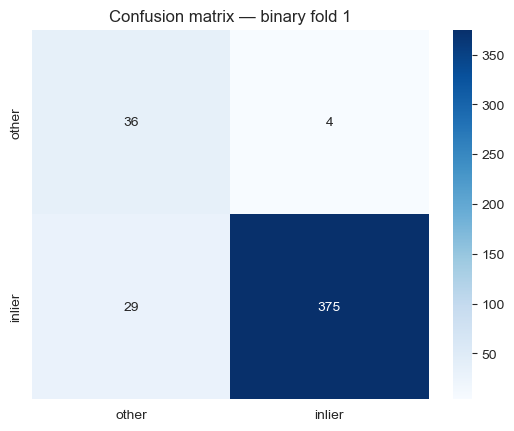


—— Binary report (fold 2) ——
              precision    recall  f1-score   support

    other(0)       0.67      0.90      0.77        40
   inlier(1)       0.99      0.96      0.97       404

    accuracy                           0.95       444
   macro avg       0.83      0.93      0.87       444
weighted avg       0.96      0.95      0.95       444

FP: 4 | FN: 18


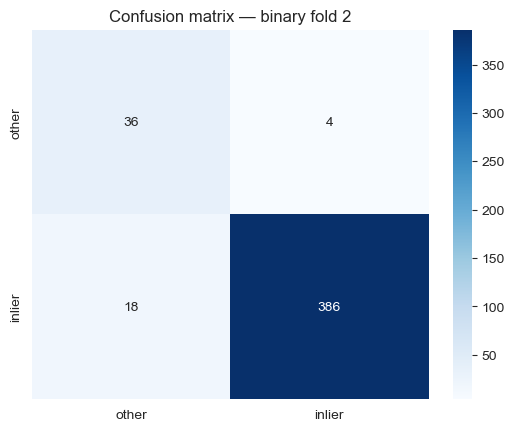


—— Binary report (fold 3) ——
              precision    recall  f1-score   support

    other(0)       0.69      0.90      0.78        41
   inlier(1)       0.99      0.96      0.97       403

    accuracy                           0.95       444
   macro avg       0.84      0.93      0.88       444
weighted avg       0.96      0.95      0.96       444

FP: 4 | FN: 17


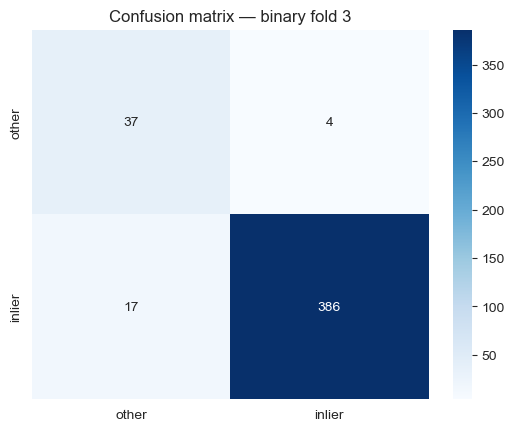


—— Binary report (fold 4) ——
              precision    recall  f1-score   support

    other(0)       0.72      0.95      0.82        40
   inlier(1)       0.99      0.96      0.98       403

    accuracy                           0.96       443
   macro avg       0.86      0.96      0.90       443
weighted avg       0.97      0.96      0.96       443

FP: 2 | FN: 15


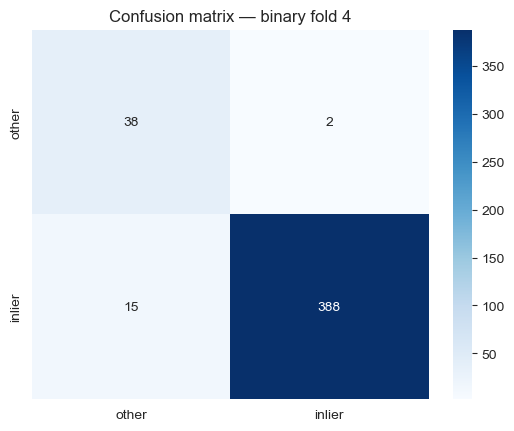


—— Binary report (fold 5) ——
              precision    recall  f1-score   support

    other(0)       0.59      0.88      0.71        40
   inlier(1)       0.99      0.94      0.96       403

    accuracy                           0.93       443
   macro avg       0.79      0.91      0.84       443
weighted avg       0.95      0.93      0.94       443

FP: 5 | FN: 24


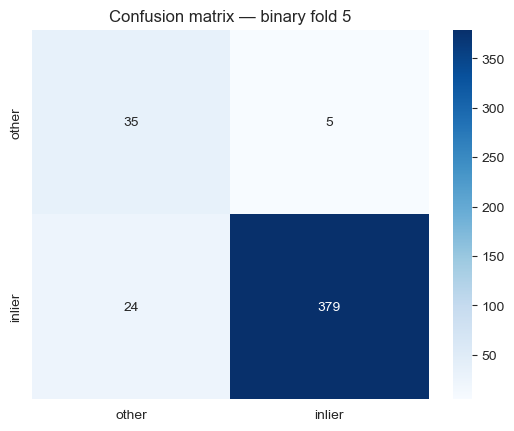


—— Multiclass report (fold 1) ——
                            precision    recall  f1-score   support

              accept_order       0.92      1.00      0.96        35
               build_route       0.88      0.96      0.91        45
             business_trip       0.75      0.87      0.81        31
            call_passenger       0.98      0.98      0.98        43
             change_tariff       0.97      0.93      0.95        30
        find_nearby_places       0.96      1.00      0.98        27
                   go_home       0.84      0.73      0.78        37
    read_passenger_message       0.89      0.97      0.93        32
read_passenger_preferences       1.00      0.92      0.96        49
              reject_order       1.00      0.87      0.93        46

                  accuracy                           0.92       375
                 macro avg       0.92      0.92      0.92       375
              weighted avg       0.92      0.92      0.92       375


—— Multicl

In [34]:
 # ────────────────────── 0. Imports ──────────────────────
import numpy as np, pandas as pd, torch, warnings, seaborn as sns, matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
warnings.filterwarnings("ignore")

# ────────────────────── 1. BERT embedder ─────────────────
class BertEmbedder:
    def __init__(self):
        self.tok  = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
        self.mod  = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
        self.dev  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.mod.to(self.dev); print(f"BertEmbedder on {self.dev}")

    def embed(self, txt: str) -> np.ndarray:
        t = self.tok(txt, truncation=True, padding=True, return_tensors="pt")
        t = {k: v.to(self.dev) for k, v in t.items()}
        with torch.no_grad():
            v = self.mod(**t).last_hidden_state[:, 0, :]
        return torch.nn.functional.normalize(v)[0].cpu().numpy()

# ────────────────────── 2. Data prep ─────────────────────
data = pd.read_csv("dataset_6k_10_classes.csv", sep=";")                 # «text», «label»
y_bin  = (data["label"] != "other").astype(int)         # 1 = inlier
y_mult = data["label"]
embedder = BertEmbedder()
X = np.vstack([embedder.embed(t) for t in data["text"]])

# Helpers
N_FOLDS = 5
BIN_THRESH = 0.92

# ─────────────── 3. Binary layer: 5-fold CV ─────────────
skf_bin = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
y_bin_oof, y_bin_pred = np.zeros(len(X)), np.zeros(len(X))

for f, (tr, te) in enumerate(skf_bin.split(X, y_bin), 1):
    X_tr, X_te, y_tr, y_te = X[tr], X[te], y_bin.iloc[tr], y_bin.iloc[te]

    scale_pos = (y_tr==0).sum()/(y_tr==1).sum()
    cb_bin = CatBoostClassifier(iterations=500, learning_rate=0.05,
                                scale_pos_weight=scale_pos, random_seed=42, verbose=0)
    cb_bin.fit(X_tr, y_tr)

    prob = cb_bin.predict_proba(X_te)[:,1]
    y_hat = (prob >= BIN_THRESH).astype(int)

    # сохранение в oof-массивы
    y_bin_oof[te]  = y_te
    y_bin_pred[te] = y_hat

    # привычный отчёт/матрица
    print(f"\n—— Binary report (fold {f}) ——")
    print(classification_report(y_te, y_hat, target_names=["other(0)", "inlier(1)"]))
    print("FP:", ((y_hat==1)&(y_te==0)).sum(),
          "| FN:", ((y_hat==0)&(y_te==1)).sum())

    cm = confusion_matrix(y_te, y_hat)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["other","inlier"], yticklabels=["other","inlier"])
    plt.title(f"Confusion matrix — binary fold {f}")
    plt.show()

# ─────────────── 4. Multiclass layer: CV + bagging ───────────
skf_multi = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
y_final_pred = np.array(["other"]*len(X), dtype=object)

depths, lrs, regs = [6, 8], [0.03, 0.05], [3, 5]

for f, (tr, te) in enumerate(skf_multi.split(X, y_bin), 1):
    mask_inl_tr = (y_bin.iloc[tr] == 1)
    mask_inl_te = (y_bin_pred[te] == 1)

    X_tr_inl, y_tr_inl = X[tr][mask_inl_tr], y_mult.iloc[tr][mask_inl_tr]
    X_te_inl, y_te_inl = X[te][mask_inl_te], y_mult.iloc[te][mask_inl_te]

    mask_tr_keep = (y_tr_inl != "other")
    mask_te_keep = (y_te_inl != "other")
    X_tr_inl, y_tr_inl = X_tr_inl[mask_tr_keep], y_tr_inl[mask_tr_keep]
    X_te_inl, y_te_inl = X_te_inl[mask_te_keep], y_te_inl[mask_te_keep]

    lbls = sorted(y_tr_inl.unique())
    lid  = {l: i for i, l in enumerate(lbls)}
    y_tr_int = np.array([lid[l] for l in y_tr_inl])
    y_te_int = np.array([lid[l] for l in y_te_inl])

    probs = np.zeros((len(X_te_inl), len(lbls)))
    for m in range(4):
        samp = np.random.choice(len(X_tr_inl), int(0.8 * len(X_tr_inl)), replace=True)
        cb = CatBoostClassifier(
            loss_function="MultiClass",
            iterations=500,
            depth=depths[m % 2],
            learning_rate=lrs[m % 2],
            l2_leaf_reg=regs[m % 2],
            random_seed=10 * f + m,
            verbose=0
        )
        cb.fit(X_tr_inl[samp], y_tr_int[samp])
        probs += cb.predict_proba(X_te_inl) / 4

    y_hat_int = probs.argmax(1)
    print(f"\n—— Multiclass report (fold {f}) ——")
    print(classification_report(y_te_int, y_hat_int, target_names=lbls))

    y_final_pred[te[mask_inl_te][mask_te_keep]] = [lbls[i] for i in y_hat_int]


BertEmbedder on cpu

—— Binary report (fold 1) ——
              precision    recall  f1-score   support

    other(0)       0.83      0.98      0.90        58
   inlier(1)       1.00      0.96      0.98       312

    accuracy                           0.96       370
   macro avg       0.91      0.97      0.94       370
weighted avg       0.97      0.96      0.97       370

FP: 1 | FN: 12


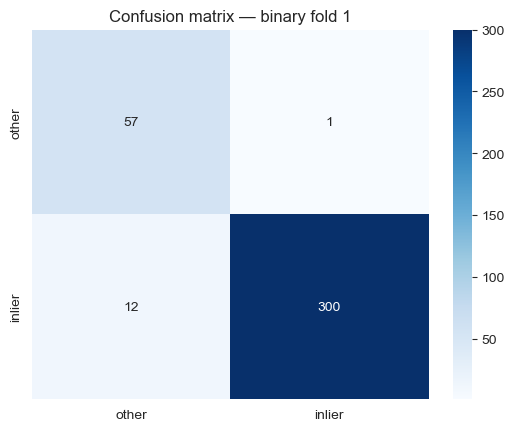


—— Binary report (fold 2) ——
              precision    recall  f1-score   support

    other(0)       0.90      0.98      0.94        57
   inlier(1)       1.00      0.98      0.99       312

    accuracy                           0.98       369
   macro avg       0.95      0.98      0.96       369
weighted avg       0.98      0.98      0.98       369

FP: 1 | FN: 6


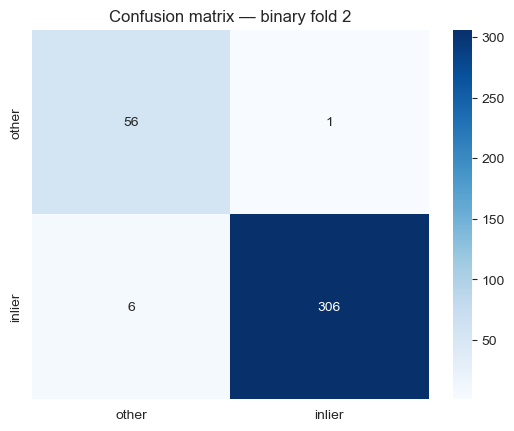


—— Binary report (fold 3) ——
              precision    recall  f1-score   support

    other(0)       0.89      1.00      0.94        58
   inlier(1)       1.00      0.98      0.99       311

    accuracy                           0.98       369
   macro avg       0.95      0.99      0.97       369
weighted avg       0.98      0.98      0.98       369

FP: 0 | FN: 7


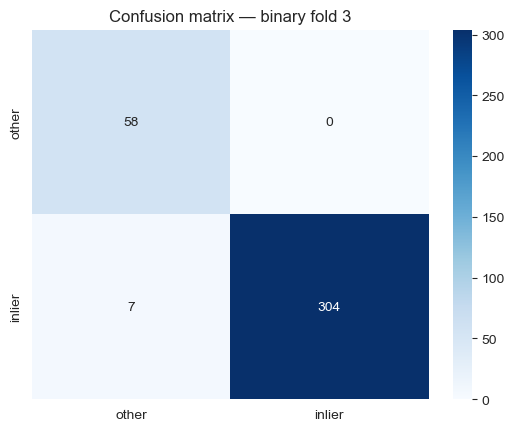


—— Binary report (fold 4) ——
              precision    recall  f1-score   support

    other(0)       0.90      0.97      0.93        58
   inlier(1)       0.99      0.98      0.99       311

    accuracy                           0.98       369
   macro avg       0.95      0.97      0.96       369
weighted avg       0.98      0.98      0.98       369

FP: 2 | FN: 6


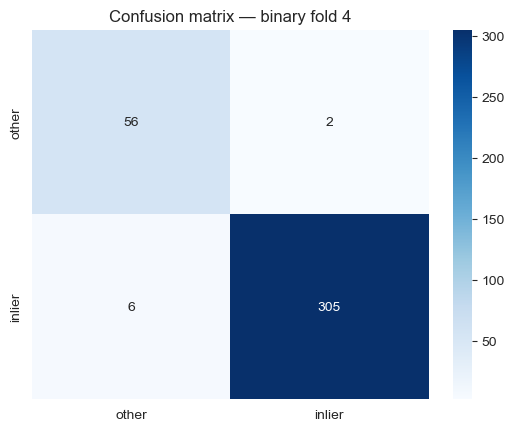


—— Binary report (fold 5) ——
              precision    recall  f1-score   support

    other(0)       0.85      0.98      0.91        58
   inlier(1)       1.00      0.97      0.98       311

    accuracy                           0.97       369
   macro avg       0.92      0.98      0.95       369
weighted avg       0.97      0.97      0.97       369

FP: 1 | FN: 10


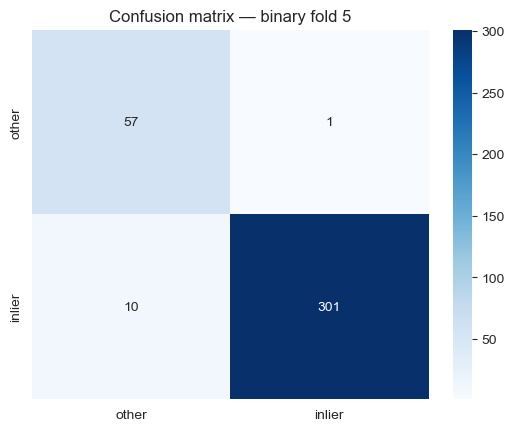


—— Multiclass report (fold 1) ——
              precision    recall  f1-score   support

      accept       0.98      0.96      0.97        52
    buisness       0.97      0.99      0.98        72
     decline       0.96      0.98      0.97        47
        home       0.99      0.96      0.98        84
       route       0.96      0.98      0.97        45

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300


—— Multiclass report (fold 2) ——
              precision    recall  f1-score   support

      accept       0.98      0.92      0.95        65
    buisness       0.96      1.00      0.98        77
     decline       0.93      0.96      0.94        52
        home       0.97      0.97      0.97        66
       route       0.98      0.96      0.97        46

    accuracy                           0.96       306
   macro avg       0.96      0.96      0.96       306
weighted 

In [2]:
 # ────────────────────── 0. Imports ──────────────────────
import numpy as np, pandas as pd, torch, warnings, seaborn as sns, matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
warnings.filterwarnings("ignore")

# ────────────────────── 1. BERT embedder ─────────────────
class BertEmbedder:
    def __init__(self):
        self.tok  = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
        self.mod  = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
        self.dev  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.mod.to(self.dev); print(f"BertEmbedder on {self.dev}")

    def embed(self, txt: str) -> np.ndarray:
        t = self.tok(txt, truncation=True, padding=True, return_tensors="pt")
        t = {k: v.to(self.dev) for k, v in t.items()}
        with torch.no_grad():
            v = self.mod(**t).last_hidden_state[:, 0, :]
        return torch.nn.functional.normalize(v)[0].cpu().numpy()

# ────────────────────── 2. Data prep ─────────────────────
data = pd.read_csv("/Users/rami/Documents/yandex/driver_intention_classifier/datasets/main_dataset_v1.csv", sep=";")                 # «text», «label»
y_bin  = (data["label"] != "other").astype(int)         # 1 = inlier
y_mult = data["label"]
embedder = BertEmbedder()
X = np.vstack([embedder.embed(t) for t in data["text"]])

# Helpers
N_FOLDS = 5
BIN_THRESH = 0.92

# ─────────────── 3. Binary layer: 5-fold CV ─────────────
skf_bin = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
y_bin_oof, y_bin_pred = np.zeros(len(X)), np.zeros(len(X))

for f, (tr, te) in enumerate(skf_bin.split(X, y_bin), 1):
    X_tr, X_te, y_tr, y_te = X[tr], X[te], y_bin.iloc[tr], y_bin.iloc[te]

    scale_pos = (y_tr==0).sum()/(y_tr==1).sum()
    cb_bin = CatBoostClassifier(iterations=500, learning_rate=0.05,
                                scale_pos_weight=scale_pos, random_seed=42, verbose=0)
    cb_bin.fit(X_tr, y_tr)

    prob = cb_bin.predict_proba(X_te)[:,1]
    y_hat = (prob >= BIN_THRESH).astype(int)

    # сохранение в oof-массивы
    y_bin_oof[te]  = y_te
    y_bin_pred[te] = y_hat

    # привычный отчёт/матрица
    print(f"\n—— Binary report (fold {f}) ——")
    print(classification_report(y_te, y_hat, target_names=["other(0)", "inlier(1)"]))
    print("FP:", ((y_hat==1)&(y_te==0)).sum(),
          "| FN:", ((y_hat==0)&(y_te==1)).sum())

    cm = confusion_matrix(y_te, y_hat)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["other","inlier"], yticklabels=["other","inlier"])
    plt.title(f"Confusion matrix — binary fold {f}")
    plt.show()

# ─────────────── 4. Multiclass layer: CV + bagging ───────────
skf_multi = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
y_final_pred = np.array(["other"]*len(X), dtype=object)

depths, lrs, regs = [6, 8], [0.03, 0.05], [3, 5]

for f, (tr, te) in enumerate(skf_multi.split(X, y_bin), 1):
    mask_inl_tr = (y_bin.iloc[tr] == 1)
    mask_inl_te = (y_bin_pred[te] == 1)

    X_tr_inl, y_tr_inl = X[tr][mask_inl_tr], y_mult.iloc[tr][mask_inl_tr]
    X_te_inl, y_te_inl = X[te][mask_inl_te], y_mult.iloc[te][mask_inl_te]

    mask_tr_keep = (y_tr_inl != "other")
    mask_te_keep = (y_te_inl != "other")
    X_tr_inl, y_tr_inl = X_tr_inl[mask_tr_keep], y_tr_inl[mask_tr_keep]
    X_te_inl, y_te_inl = X_te_inl[mask_te_keep], y_te_inl[mask_te_keep]

    lbls = sorted(y_tr_inl.unique())
    lid  = {l: i for i, l in enumerate(lbls)}
    y_tr_int = np.array([lid[l] for l in y_tr_inl])
    y_te_int = np.array([lid[l] for l in y_te_inl])

    probs = np.zeros((len(X_te_inl), len(lbls)))
    for m in range(4):
        samp = np.random.choice(len(X_tr_inl), int(0.8 * len(X_tr_inl)), replace=True)
        cb = CatBoostClassifier(
            loss_function="MultiClass",
            iterations=500,
            depth=depths[m % 2],
            learning_rate=lrs[m % 2],
            l2_leaf_reg=regs[m % 2],
            random_seed=10 * f + m,
            verbose=0
        )
        cb.fit(X_tr_inl[samp], y_tr_int[samp])
        probs += cb.predict_proba(X_te_inl) / 4

    y_hat_int = probs.argmax(1)
    print(f"\n—— Multiclass report (fold {f}) ——")
    print(classification_report(y_te_int, y_hat_int, target_names=lbls))

    y_final_pred[te[mask_inl_te][mask_te_keep]] = [lbls[i] for i in y_hat_int]
